# 1. SETUP

## 1.1 Imports


In [17]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from A2C_discrete_kworkers import A2C
from tqdm import tqdm
import os
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.2 PARAMETERS SETUP


In [20]:
# HYPERPARAMETERS
# environment hyperparams
n_steps = 600000
n_envs = 3
n_steps_per_update = 1
n_updates = n_steps // (n_steps_per_update*n_envs)
evaluation_interval = 20000//(n_steps_per_update*n_envs) # evaluate the agent every 20k steps
n_eval_runs = 10 # how many evaluation runs to do each 20k steps 

# agent hyperparams
gamma = 0.99  # discount factor
ent_coef = 0.01  # coefficient for the entropy bonus (to encourage exploration)
actor_lr = 1e-5
critic_lr = 1e-3
stochasticity_bool = False
stochastic_reward_probability = 0.9
# Note: the actor has a slower learning rate so that the value targets become
# more stationary and are theirfore easier to estimate for the critic

# SEED
def set_seed(seed):
    torch.manual_seed(seed) # pytorch random seed
    np.random.seed(seed) # numpy random seed
# Set a seed value
seed_value = 50
set_seed(seed_value)

# ENVIRONMENT
envs = []
for i in range(n_envs):
    env = gym.make('CartPole-v1')
    envs.append(env)

env_eval = gym.make("CartPole-v1")
obs_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

# DEVICE
use_cuda = False
if use_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

# AGENT
agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, n_envs)

# 2. AGENT TRAINING

In [21]:
# LOGGED VARIABLES
critic_losses = []
actor_losses = []
entropies = []
episode_returns = [[] for _ in range(n_envs)] # logs the returns per episode per worker
steps_episodes = [[] for _ in range(n_envs)] # logs the steps taken in each episode per worker
evaluation_returns = [] # logs the returns of the agent during evaluation

# COUNTERS
steps = 0
steps_workers = [0] * n_envs
ep_counter = 0
ep_reward = [0] * n_envs

# VARIABLE INITIALIZATION
is_truncated = [False] * n_envs #creates a list of n_envs elements, all set to False
is_terminated = [False] * n_envs #creates a list of n_envs elements, all set to False
states = []
for i in range(n_envs):
    state, info = envs[i].reset(seed=42)  #only use the seed when resetting the first time
    states.append(state)


# use tqdm to get a progress bar for training
for steps in tqdm(range(n_updates+1)):
        

    # reset lists that collect experiences of a n_steps_per_update
    n_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
    n_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
    # don't take mask and reward gradient
    masks = torch.ones(n_steps_per_update, n_envs, device=device,requires_grad = False)
    n_rewards = torch.zeros(n_steps_per_update, n_envs, device=device,requires_grad = False)
    end_states = [[] for _ in range(n_envs)] # get a list for each env ex : [[], [], []]
    end_states_idx = [[0] for _ in range(n_envs)] # get a list for each env ex : [[0], [0], [0]]

    # play n_steps_per_update to collect data
    for step in range(n_steps_per_update):
        entropy = [0] * n_envs
        for env_idx in range(n_envs):
            # select an action A_{t} using S_{t} as input for the agent, get action and values Vt
            action, action_log_probs, V_t, entropy[env_idx] = agent.select_action(states[env_idx], bool_greedy=False)

            # ensure no grad is taken in the step
            with torch.no_grad():
                # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
                states[env_idx], reward, is_terminated[env_idx], is_truncated[env_idx], infos = envs[env_idx].step(
                    action.cpu().numpy()
                )
                steps_workers[env_idx] += 1
            if stochasticity_bool:
                # introduce stochasticity in the reward
                if np.random.rand() < stochastic_reward_probability:
                    reward = 0

            ep_reward[env_idx] += reward # increase episode return
            mask = not is_terminated[env_idx] # define mask for bootstrapping

            # log the value, reward and action log prob of the last step
            n_value_preds[step][env_idx] = torch.squeeze(V_t)
            n_rewards[step][env_idx] = torch.tensor(reward, device=device)
            n_action_log_probs[step][env_idx] = action_log_probs

            # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
            masks[step][env_idx] = torch.tensor(mask) # allows for correct bootstrapping
            
            # reset environment if truncated or terminated
            if is_terminated[env_idx] or is_truncated[env_idx]:
                states[env_idx], info = envs[env_idx].reset()

            if is_terminated[env_idx] or is_truncated[env_idx]:
                states_tensor = torch.tensor(states[env_idx], device=device) # Transform the last state reached (S_t+n) to a tensor
                end_states[env_idx].append(states_tensor)
                end_states_idx[env_idx].append(step)
                states[env_idx], info = env.reset() # do not use the seed when resetting again
                ep_counter += 1
                steps_episodes[env_idx].append(steps_workers[env_idx])
                episode_returns[env_idx].append(ep_reward[env_idx])
                ep_reward[env_idx] = 0

    
    for env_idx in range(n_envs):
        # if statement to make sure we don't append the end state twice
        if not is_terminated[env_idx] and not is_truncated[env_idx]:
            states_tensor = torch.tensor(states[env_idx], device=device) # Transform the last state reached (S_t+n) to a tensor
            end_states[env_idx].append(states_tensor)
            end_states_idx[env_idx].append(step)

    # calculate the losses for actor and critic
    critic_loss, actor_loss = agent.get_losses(
        n_rewards,
        n_action_log_probs,
        n_value_preds,
        entropy,
        masks,
        gamma,
        end_states,
        end_states_idx
    )

    # update the actor and critic networks
    agent.update_parameters(critic_loss, actor_loss)

    # log the losses and entropy
    critic_losses.append(critic_loss.detach().cpu().numpy())
    actor_losses.append(actor_loss.detach().cpu().numpy())
    entropies.append(sum(entropy) / len(entropy))

    #After every 20k steps, evaluate the performance of your agent by running it for 10 episodes with a greedy action policy (without noise)
    #on a newly initialized environment and plotting the evaluation statistics below.
    with torch.no_grad(): # No need to store gradients in the evaluation
        if steps % evaluation_interval == 0 and steps != 0:
            print("EVALUATION")
            # evaluate
            returns = []
            episode_lengths = []
            for i in range(n_eval_runs):
                # Only use the seed when resetting at the beginning to ensure the states will follow the same initialization at every evalutaion step
                if i == 0:
                    state, info = env_eval.reset(seed = seed_value)
                else:
                    state, info = env_eval.reset()
                episode_return = 0
                episode_length = 0
                while True:
                    action, _, _, _ = agent.select_action(state,bool_greedy=True)
                    state, reward, terminated, truncated, info = env_eval.step(action.cpu().numpy())
                    episode_return += reward
                    episode_length += 1
                    if terminated or truncated:
                        break
                returns.append(episode_return)
                episode_lengths.append(episode_length)  
            evaluation_returns.append(np.mean(returns))
            





  3%|▎         | 6755/200001 [00:10<05:14, 614.98it/s]

EVALUATION


  7%|▋         | 13369/200001 [00:20<05:37, 553.31it/s]

EVALUATION


 10%|█         | 20040/200001 [00:30<05:34, 537.79it/s]

EVALUATION


 13%|█▎        | 26669/200001 [00:40<05:54, 489.25it/s]

EVALUATION


 17%|█▋        | 33276/200001 [00:50<04:09, 668.52it/s]

EVALUATION


 20%|█▉        | 39934/200001 [01:00<03:57, 674.57it/s]

EVALUATION


 23%|██▎       | 46625/200001 [01:10<03:46, 678.25it/s]

EVALUATION


 27%|██▋       | 53305/200001 [01:20<03:35, 681.94it/s]

EVALUATION


 30%|██▉       | 59956/200001 [01:30<03:47, 615.11it/s]

EVALUATION


 33%|███▎      | 66657/200001 [01:41<03:16, 677.02it/s]

EVALUATION


 37%|███▋      | 73270/200001 [01:51<03:06, 679.22it/s]

EVALUATION


 40%|███▉      | 79973/200001 [02:02<02:57, 674.69it/s]

EVALUATION


 43%|████▎     | 86638/200001 [02:12<03:11, 590.64it/s]

EVALUATION


 47%|████▋     | 93291/200001 [02:22<02:37, 675.74it/s]

EVALUATION


 50%|████▉     | 99932/200001 [02:32<02:26, 681.30it/s]

EVALUATION


 53%|█████▎    | 106592/200001 [02:43<02:35, 602.46it/s]

EVALUATION


 57%|█████▋    | 113322/200001 [02:54<02:22, 610.21it/s]

EVALUATION


 60%|█████▉    | 119951/200001 [03:04<01:58, 675.57it/s]

EVALUATION


 63%|██████▎   | 126619/200001 [03:15<02:04, 588.09it/s]

EVALUATION


 67%|██████▋   | 133265/200001 [03:26<01:40, 666.04it/s]

EVALUATION


 70%|██████▉   | 139935/200001 [03:36<01:29, 670.93it/s]

EVALUATION


 73%|███████▎  | 146617/200001 [03:47<01:27, 609.76it/s]

EVALUATION


 77%|███████▋  | 153272/200001 [03:58<01:09, 669.81it/s]

EVALUATION


 80%|███████▉  | 159953/200001 [04:08<00:59, 671.09it/s]

EVALUATION


 83%|████████▎ | 166641/200001 [04:19<00:49, 680.02it/s]

EVALUATION


 87%|████████▋ | 173289/200001 [04:29<00:39, 672.40it/s]

EVALUATION


 90%|████████▉ | 179930/200001 [04:40<00:30, 667.12it/s]

EVALUATION


 93%|█████████▎| 186602/200001 [04:51<00:21, 633.18it/s]

EVALUATION


 97%|█████████▋| 193281/200001 [05:02<00:10, 662.24it/s]

EVALUATION


100%|█████████▉| 199955/200001 [05:13<00:00, 673.49it/s]

EVALUATION


100%|██████████| 200001/200001 [05:13<00:00, 637.58it/s]


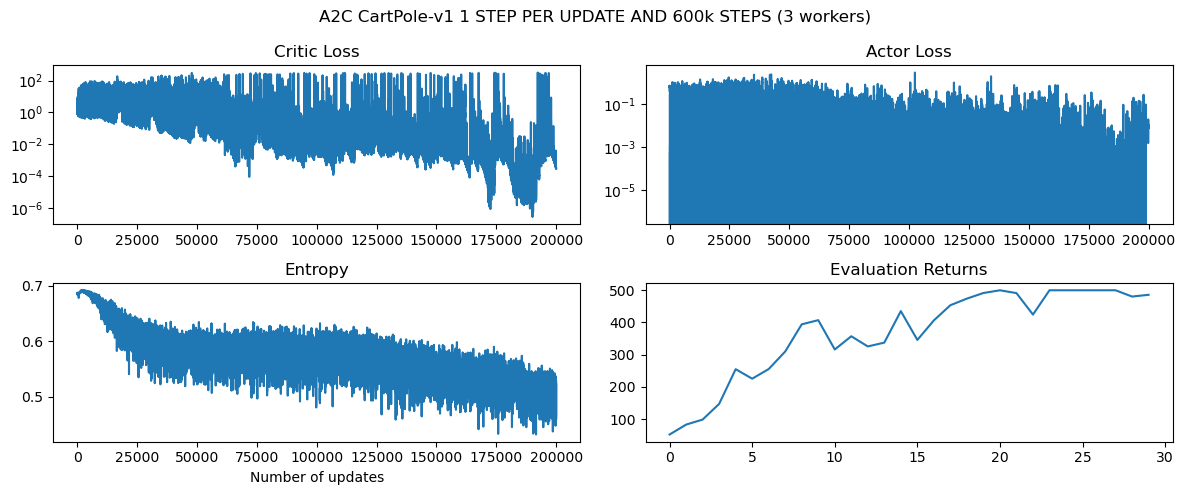

In [27]:
rolling_length = 30

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
#set title of the plot
fig.suptitle("A2C CartPole-v1 1 STEP PER UPDATE AND 600k STEPS (3 workers)")
critic_losses = np.array(critic_losses)
capped_loss = critic_losses[critic_losses < 1]
critic_ma = (
    np.convolve(np.array(critic_losses), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[0, 0].plot(critic_ma)
axs[0, 0].set_title('Critic Loss')
axs[0, 0].set_yscale('log')  # Set log scale for the y-axis
actor_ma = (
    np.convolve(np.array(actor_losses), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[0, 1].plot(actor_ma)
axs[0, 1].set_title('Actor Loss')
axs[0, 1].set_yscale('log')  # Set log scale for the y-axis


# entropy
axs[1][0].set_title("Entropy")
entropy_moving_average = (
    np.convolve(np.array(entropies), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][0].plot(entropy_moving_average)
axs[1][0].set_xlabel("Number of updates")



#axs[1, 1].plot(steps_episodes, episode_returns)
#axs[1, 1].set_title('Episode Rewards')
axs[1, 1].plot(evaluation_returns)
axs[1, 1].set_title('Evaluation Returns')
plt.tight_layout()
plt.show()


In [151]:
#save the plot
fig.savefig("A2C_boot_1step_stochastic_2.png")

In [75]:
len(episode_returns)
steps_episodes

[[12,
  28,
  44,
  53,
  80,
  118,
  150,
  186,
  200,
  216,
  237,
  307,
  350,
  378,
  409,
  428,
  447,
  478,
  493,
  513,
  572,
  592,
  617,
  630,
  643,
  654,
  688,
  700,
  717,
  730,
  743,
  759,
  772,
  785,
  810,
  838,
  862,
  893,
  926,
  937,
  951,
  992,
  1014,
  1025,
  1079,
  1096,
  1117,
  1128,
  1146,
  1159,
  1178,
  1199,
  1231,
  1256,
  1271,
  1302,
  1311,
  1326,
  1337,
  1347,
  1387,
  1399,
  1413,
  1430,
  1489,
  1498,
  1508,
  1529,
  1550,
  1570,
  1587,
  1597,
  1628,
  1641,
  1658,
  1691,
  1732,
  1743,
  1759,
  1793,
  1810,
  1832,
  1857,
  1897,
  1906,
  1931,
  1953,
  2029,
  2042,
  2066,
  2096,
  2107,
  2128,
  2156,
  2191,
  2214,
  2239,
  2251,
  2277,
  2293,
  2311,
  2325,
  2352,
  2395,
  2427,
  2449,
  2463,
  2493,
  2504,
  2519,
  2534,
  2547,
  2584,
  2615,
  2630,
  2650,
  2664,
  2701,
  2719,
  2742,
  2755,
  2798,
  2833,
  2862,
  2882,
  2895,
  2906,
  2915,
  2935,
  2955,
  2967,

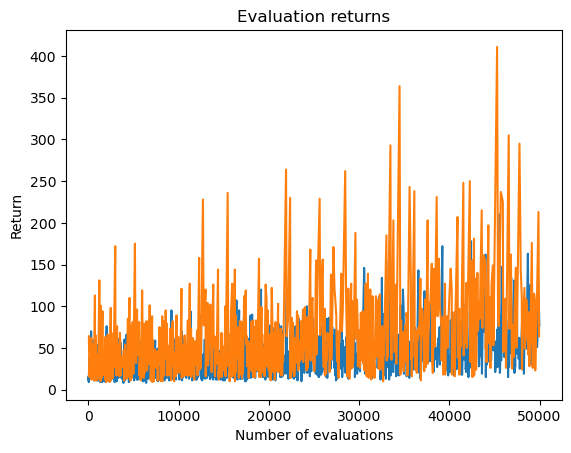

In [78]:
plt.plot(steps_episodes[0],episode_returns[0])
plt.plot(steps_episodes[1],episode_returns[1])
plt.title("Evaluation returns")
plt.xlabel("Number of evaluations")
plt.ylabel("Return")
plt.show()

## saving/loading weights

In [9]:
save_weights = True
load_weights = False

actor_weights_path = "weights/actor_weightss.h5"
critic_weights_path = "weights/critic_weightss.h5"

if not os.path.exists("weights"):
    os.mkdir("weights")

""" save network weights """
if save_weights:
    torch.save(agent.actor.state_dict(), actor_weights_path)
    torch.save(agent.critic.state_dict(), critic_weights_path)


""" load network weights """
if load_weights:
    agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, 1)

    agent.actor.load_state_dict(torch.load(actor_weights_path))
    agent.critic.load_state_dict(torch.load(critic_weights_path))
    agent.actor.eval()
    agent.critic.eval()

## SHOWCASE

In [10]:
n_showcase_episodes = 3

for episode in range(n_showcase_episodes):
    print(f"starting episode {episode}...")

    # create a new sample environment to get new random parameters
    env = gym.make("CartPole-v1", render_mode="human", max_episode_steps=500)

    # get an initial state
    state, info = env.reset()

    # play one episode
    done = False
    while not done:
        # select an action A_{t} using S_{t} as input for the agent
        with torch.no_grad():
            action, _, _, _ = agent.select_action(state[None, :], bool_greedy=True)

        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(action.item())

        # update if the environment is done
        done = terminated or truncated

env.close()

starting episode 0...


/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


starting episode 1...
starting episode 2...


: 

### 1.2.1 Printing informations

In [ ]:
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")
print("------")
print(f"Number of actions available: {env.action_space.n}")
print(f"Observation shape: {env.observation_space.shape}")

NameError: name 'env' is not defined

## 1.3 Define the A2C Class


# 2. Running the Agents (Discrete Case)


A2C.py and then we merge


In [ ]:
from A2C import *

## 1.4 Training function



train.py and then we merge


In [ ]:
from training import *

## 1.5 Evaluation functions

# 2. Running the Agents (Discrete Case)


## 2.1 Agent 1

# 3. Running the Agents (Continuous Case)
